# Course 2: Project - Task D - Time-series analysis

<a name="task-d-top"></a>
This notebook is concerned with task D.

**Contents:**
* [Imports](#task-d-imports)
* [Data loading](#task-d-data-loading)
* [Mean time difference](#task-d-mean-time-difference)
* [Number of items](#task-d-number-of-items)

## Imports<a name="task-c-imports"></a> ([top](#task-d-top))
---

In [46]:
# Standard library:
import itertools
import pathlib
import re
import typing as t
import unicodedata

# 3rd party:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Project:
import ingredients
import utils

%matplotlib inline
register_matplotlib_converters()

## Data loading<a name="task-d-data-loading"></a> ([top](#task-d-top))
---

First, we load the subset of the cleaned-up dataset that we need:

In [47]:
base_name = pathlib.Path.cwd().joinpath('en.openfoodfacts.org.products.clean')

In [49]:
# The columns to load:
usecols=['created_on_utc', 'last_modified_on_utc']

# Load:
data_types, parse_dates  = utils.amend_dtypes(utils.load_dtypes(base_name))
# We can only parse dates in the columns that we are loading:
parse_dates = list(set(parse_dates) & set(usecols))
df = pd.read_csv(
        f'{base_name}.csv',
        header=0,
        parse_dates=parse_dates,
        usecols=usecols,
        dtype=data_types)

We get some general information:

In [50]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355569 entries, 0 to 355568
Data columns (total 2 columns):
created_on_utc          355569 non-null datetime64[ns]
last_modified_on_utc    355569 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 5.4 MB


We look at the first few rows:

In [51]:
df.head()

,created_on_utc,last_modified_on_utc
0,2016-09-17 09:17:46,2016-09-17 09:18:13
1,2017-03-09 14:32:37,2017-03-09 14:32:37
2,2017-03-09 14:32:37,2017-03-09 14:32:37
3,2017-03-09 10:35:31,2017-03-09 10:35:31
4,2017-03-09 10:34:13,2017-03-09 10:34:13


## Mean time difference<a name="task-d-mean-time-difference"></a> ([top](#task-d-top))
---

**Task:** Analyze the mean time difference between `created_on_utc` and `last_modified_on_utc`.

From task A, we know that both values are always set together and that `created_on` always precede `last_modified_on`.

In [54]:
difference = df['last_modified_on_utc'] - df['created_on_utc']
print(f'mean time difference: {str(difference.mean().to_pytimedelta())}')

mean time difference: 108 days, 4:23:48.361964


## Number of items<a name="task-d-number-of-items"></a> ([top](#task-d-top))
---

**Taks:** Analyze the total number of items created each month over the full timeline of the data. Choose an appropriate method to visualize your findings.

In [76]:
df_items = df[['created_on_utc']]
df_items['count'] = 1
df_items = df_items.set_index('created_on_utc')
# Make sure that the entries are sorted:
df_items.sort_index()  
# Sum by month:
df_result = df_items.resample('M').sum()
df_result = df_result.rename(columns={'count': 'sum'})
# Compute the cumulative sum:
df_result['cum_sum'] = df_result['sum'].cumsum()
# Reset the index:
df_result = df_result.reset_index()

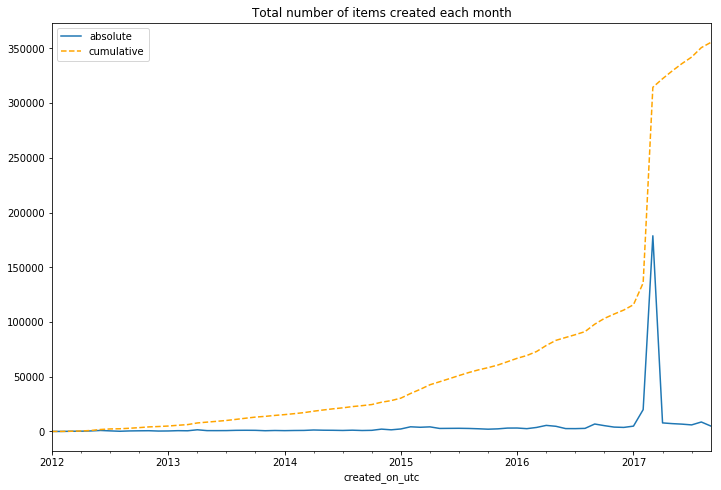

In [80]:
# https://stackoverflow.com/a/22787457
def cm2inch(*tupl):
    inch = 2.54  # cm
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


# Default figure size seems to be 6 x 4 inches = 15.24 x 10.16 cm
fig, ax = plt.subplots(figsize=cm2inch(30, 20))
ax.set_title('Total number of items created each month')
df_result.plot(x="created_on_utc", y="sum", label='absolute', ax=ax)
ax.set_xlabel('timeline (UTC)')
df_result.plot(x="created_on_utc", y="cum_sum", label='cumulative', color="orange", style='--', ax=ax)
plt.show()

We see that there was a huge increase in the first half of 2017, which is confirmed by looking at the data:

In [72]:
df_result[(df_result['created_on_utc'] > pd.Timestamp('2017-01-01')) &
          (df_result['created_on_utc'] < pd.Timestamp('2017-07-01'))]

,created_on_utc,sum,cum_sum
60,2017-01-31,4854,115789
61,2017-02-28,19928,135717
62,2017-03-31,178777,314494
63,2017-04-30,7797,322291
64,2017-05-31,7141,329432
65,2017-06-30,6675,336107
